# $\mathtt{Relax\_Æ}$ wrapper tutorial

In [2]:
# Common python packages
import os
from scipy import integrate
import matplotlib.pyplot as plt
cc = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

# Check that pwd is relaxation directory and code is compiled
if os.path.exists(os.getcwd()+'/wrapper_tutorial.ipynb'):
    os.chdir('../..') # May need to be set by hand if nonconventional setup
if not os.path.exists(os.getcwd()+'/bin/relaxed_ae'):
    print('ERROR: relaxation code not found!\n'
          '       Either not compiled, or not in relaxation code directory')
    assert(False)

# Wrapper modules
from wrapper.relax_wrapper import wind_simulation as wind_sim
from wrapper.wrapper_utils import constants as const
from wrapper.wrapper_utils.system import system
from wrapper.wrapper_utils.physics import physics
from wrapper.wrapper_utils.plots import *

# Check if McAstro loaded
McAstro_loaded = False
if os.path.exists('McAstro/planets/insolation/glq_rates.py'):
    McAstro_loaded = True
if McAstro_loaded:
    from wrapper.wrapper_utils.spectrum import spectrum
else:
    print('WARNING: McAstro not found. Running limited capabilities.')

## Create systems

You create systems by suppling a planetary mass ($M_\mathrm{p}$), planetary radius ($R_\mathrm{p}$), stellar mass ($M_\star$), semimajor-axis ($a$), and the total integrated ionizing flux ($F_\mathrm{uv}$).

The supplied planetary radius is assumed to be the often widely cited optical transit radius from optical observations (as the uv transit radius should be near impossible to measure observationally). Therefore, one needs to consider how to extrapolate the radius at which the ionizing energy is deposited. More on this later when we get to the `atmosphere` object.

Here are examples of several well known systems we create as `system` objects.

In [3]:
HD189733b = system(1.162*const.Mjupiter, 1.138*const.Rjupiter,
                   0.846*const.Msun, 0.031*const.au, 2000,
                   name='HD 189733 b') #Rstar = 0.8*Rsun

HD209458b = system(0.71*const.Mjupiter, 1.35*const.Rjupiter,
                   1.26*const.Msun, 0.045*const.au, 2000, 
                   name='HD 209458 b')

Kelt9b = system(5.1e30, 1.35e10, 5e33, 5.18e11, 1.82e4,
                name='Kelt-9 b') #Rstar = 2.4*Rsun

GJ436b = system(1.28e29, 2.75e9, 8.16e32, 4.19e11, 765,
                name='GJ 436 b')

LTT9779b = system(29.32*const.Mearth, 4.59*const.Rearth,
                  const.Msun, 0.016969*const.au, 450*(0.05/0.016969)**2,
                  name='LTT 9779 b')

TOI_1231 = system(15.1*const.Mearth, 3.95*const.Rearth,
                  0.461*const.Msun, 0.1266*const.au, 205,
                  name='TOI 1231')

GJ3470b = system(0.043*const.Mjupiter, 0.35*const.Rjupiter,
                 0.51*const.Msun, 0.031*const.au, 450*(0.05/0.031)**2,
                 name='GJ 3470 b')

GJ1214b = system(6.55*const.Mearth, 2.678*const.Rearth,
                 0.157*const.Msun, 0.0143*const.au, 450*(0.05/0.0143)**2,
                 name='GJ 1214 b')

WASP_12_b = system(1.465*const.Mjupiter, 1.937*const.Rjupiter,
                   1.434*const.Msun, 0.02320*const.au, 51082,
                   name='WASP-12 b')

McCann19 = system(5e29, 1.5e10, const.Msun, 1e12, 515,
                  name='McCann 2019')

MurrayClay09_lo = system(1.33e30, 1e10, const.Msun, 0.05*const.au, 450,
                         name='Murray-Clay 2009 (lo flux)')

MurrayClay09_hi = system(1.33e30, 1e10, const.Msun, 0.05*const.au, 5e5,
                      name='Murray-Clay 2009 (hi flux)')

## Reviewing systems

At anytime you can print the system parameters to remind yourself what the parameters have been set to with `system.print_system()`. You can provide the keyword argument `norm` to change which normalized units are used for the display. Currently, the only options are 'Earth' and 'Jupiter' (of which Jupiter is the default).

In [4]:
HD209458b.print_system()
GJ436b.print_system(norm='Earth')
GJ3470b.print_system(norm='Earth')

HD 209458 b:
  System parameters (cgs)               # Normalized units
    Mp:        1.347952e+30 g           #     0.71 MJ
    Rp:        9.651420e+09 cm          #     1.35 RJ
    Mstar:     2.505404e+33 g           #     1.26 Msun
    semimajor: 6.732000e+11 cm          #     0.04 au
    Fuv:       2.000000e+03 erg/cm^2/s  # 4.29e+02 FuvEarth

GJ 436 b:
  System parameters (cgs)               # Normalized units
    Mp:        1.280000e+29 g           #    21.43 ME
    Rp:        2.750000e+09 cm          #     4.31 RE
    Mstar:     8.160000e+32 g           #     0.41 Msun
    semimajor: 4.190000e+11 cm          #     0.03 au
    Fuv:       7.650000e+02 erg/cm^2/s  # 1.64e+02 FuvEarth

GJ 3470 b:
  System parameters (cgs)               # Normalized units
    Mp:        8.163651e+28 g           #    13.67 ME
    Rp:        2.502220e+09 cm          #     3.92 RE
    Mstar:     1.014092e+33 g           #     0.51 Msun
    semimajor: 4.637600e+11 cm          #     0.03 au
    Fuv:     

## Create the simulation object

The class `wind_simulation`, which we imported as `wind_sim`, is the main object that the end user will use to control the entire relaxation environment. By calling the class it will automatically be initialized to load the solution prescribed by `inputs/guess.inp`. If you wish to load a different solution you can provide the keyword argument `csv_file`, e.g., `csv_file=saves/windsoln.csv`, when initializing. You may also provide the keyword argument `name` for plotting purposes, and will set the `wind_simulations`'s `system` object's name attribute. 

Here we initialize a `wind_simulation` object and assign it to `sim`. A `wind_simulation` object, here assigned to `sim`, has it's own `wind_soluton`, `system`, `atmosphere` and `physics` objects. The `wind_solution` object is access via `sim.windsoln`, the `system` via `sim.system`, the atmosphere as `sim.atmosphere`, and the physics by `sim.physics`. We will discuss below what the other objects are, but for now we will just print the `system` parameters by doing `sim.system.print_system()`.

In [2]:
sim = wind_sim()
sim.system.print_system(norm='Jupiter')

Init. Planet:
  System parameters (cgs)               # Normalized units
    Mp:        1.330000e+30 g           #     0.70 MJ
    Rp:        1.000000e+10 cm          #     1.40 RJ
    Mstar:     1.988416e+33 g           #     1.00 Msun
    semimajor: 7.480000e+11 cm          #     0.05 au
    Fuv:       4.500000e+02 erg/cm^2/s  # 9.64e+01 FuvEarth



## Loading solutions

With a `wind_simulation` object a user can also load a previous solution with the `load_planet` method. Note that this solution could have been similarly loaded during the `wind_simulation` object initialization by providing the `csv_file` keyword argument, but it also provides the user with the ability to load a solution even after the object has been initialized.

**WARNING:** Loading a solution will overwrite the files in `inputs/` such that they match those that resulted in the solution we are loading. This shouldn't really be an issue for most use cases, but you have been forewarned. This should rather be seen as refreshing the relaxation environment to a previous state, in case you found yourself somewhere you didn't want to be. Therefore, it is possible to lose any currently altered solutions that have not been saved yet. We will talk about saving later in this tutorial, but for now we load the same `inputs/guess.inp` as a pedagogical example.

In [ ]:
sim.load_planet('inputs/guess.inp')

## Reviewing Atmospheres

Now recall the issue of translating the optical radius to the radius where the ionizing energy is deposited. The relaxation code attacks the problem from the top-down by setting a density at the inner boundary such that all the ionizing photons are absorbed and do not pass thru the inner boundary. Therefore, one needs to model from the bottom-up where this density resides in the planet's upper stratosphere. 

In the default configuration, we taken an optical opacity to calculate the density at the observed optical transit radius, taking into account the transit's geometry. We also provide an option to assign the density/pressure at the optical radius if you feel that is better constrained than the opacity. By assuming an isothermal atmosphere, we then have a determined toy model of the planet's upper stratosphere, from which we can map the density from the relaxation simulation to the radius given by our toy model.

This is all contained in what we call an `atmosphere` object, which was previously mentioned being one of the objects in a `wind_simulation` object (e.g., `sim.atmosphere`). We can print what the parameters of the atmosphere are with `atmosphere.print_atmosphere()`.

In [ ]:
sim.atmosphere.print_atmosphere()

Currently, the upper atmosphere is modeled by taking the parameters at the inner boundary of the relaxation result, i.e., the isothermal temperature is `T_rmin`, and the mean molecular weight equals the mean ion weight (assumes completely neutral and that hydrogen is actually diatomic). Thus, the only free parameter for the atmosphere then is the optical opacity, which we set to $\kappa_{\mathrm{opt.}} = 10^{-2}$, and can be modify with `sim.atmosphere.assign('kappa_opt', value)`. If altering the opacity then the solution will most likely need to be converged again as `Rmin`, where the `rho_rmin` maps to, will change. If one prefers they can also use a pressure at the observed radius with `sim.atmosphere.assign('P_obs', value)`.

To update the solution to a newly selected opacity (or observed pressure) simply converge the boundary conditions with `sim.converge_all_bcs(expedite=True)`. Here we give the keyword argument `expedite=True` to quickly converge the simulation without doing extra integration outside the relaxation region. We will cover this more later.

Here we show what $\kappa_{\mathrm{opt.}}$, $R_{\mathrm{min}}$, $\dot{M}_{\mathrm{3D}}$ are before and after altering our choices. We see that the results have some dependency on our choice, which mainly comes down to the radius at which the wind is being launched. Overall, the difference is not dramatic but helps one understand to what extent the modeling below the wind base alters the results.

In [ ]:
sim.converge_all_bcs(expedite=True)
print(f'\rWith kappa_opt={sim.atmosphere.kappa_opt:g}, '
      f'Rmin={sim.windsoln.Rmin:g}, Mdot={sim.windsoln.Mdot:.3e}'
      '\n')

sim.atmosphere.assign('kappa_opt', 1e-3)
sim.atmosphere.print_atmosphere()

sim.converge_all_bcs(expedite=True)
print(f'\rWith kappa_opt={sim.atmosphere.kappa_opt:g}, '
      f'Rmin={sim.windsoln.Rmin:g}, Mdot={sim.windsoln.Mdot:.3e}')

## Reviewing the relaxation solution

The `wind_simulation` class also contains a `wind_solution` object that has everything to do with the relaxation code's results. The main results are stored in a pandas DataFrame. There is the normalized results which the relaxation code uses directly, and the c.g.s. unit system results. The normalized solution is found under `sim.windsoln.soln_norm`, while the c.g.s unit system results are assigned to `sim.windsoln.soln`.

In [ ]:
sim.windsoln.soln_norm

The `soln` DataFrame will also have numerous user defined variables calculated in post-processing. These are not used by the relaxation simulation directly, but are useful for analysis. You can also add your own by modifying `wrapper_utils/windsoln.py`'s `add_user_vars()` method. Note that this will only be added if the the `wind_solution` object was called without the `expedite` flag. If you find that the `wind_solution` was loaded expeditiously (has only the variables found in `soln_norm`) then you can reload the solution file in full glory with `sim.load_nonexpedited(file_path)`. Notice this takes a bit longer to perform all the extra calculations and why it is generally avoided until the user request such results. The main culprit being the Coriolis ballistic trajectory calculations.

To load the user variables, which performing the Coriolis calculations you can use `sim.load_uservars()`.

In [3]:
sim.load_uservars()
sim.windsoln.soln

,r,rho,v,T,Ys,Ncol,q,z,mu,P,...,bern_isen,bern,ad_prof,static_prof,static_rho,static_P,static_T,del_ad,Gamma_2,Gamma_3
0,2.475000e+09,2.219919e-10,5.350346e-01,4360.953653,1.000000,4.068487e+22,-0.069954,8.957373e+09,1.673300e-24,7.987867e+01,...,-1.974806e+14,-1.974806e+14,1.770659,4.360807,2.219807e-10,79.871949,4360.806856,0.400000,1.666667,1.666667
1,2.475627e+09,2.216699e-10,5.355405e-01,4356.735972,1.000000,4.060181e+22,-0.069884,8.957373e+09,1.673300e-24,7.968567e+01,...,-1.974806e+14,-1.974806e+14,1.770437,4.356589,2.216587e-10,79.678969,4356.589322,0.400000,1.666667,1.666667
2,2.476253e+09,2.213482e-10,5.360473e-01,4352.520439,1.000000,4.051886e+22,-0.069814,8.957373e+09,1.673300e-24,7.949306e+01,...,-1.974806e+14,-1.974806e+14,1.770214,4.352374,2.213371e-10,79.486368,4352.373936,0.400000,1.666667,1.666667
3,2.476880e+09,2.210269e-10,5.365551e-01,4348.307052,1.000000,4.043603e+22,-0.069744,8.957373e+09,1.673300e-24,7.930082e+01,...,-1.974806e+14,-1.974806e+14,1.769992,4.348161,2.210158e-10,79.294144,4348.160695,0.400000,1.666667,1.666667
4,2.477506e+09,2.207059e-10,5.370637e-01,4344.095808,1.000000,4.035332e+22,-0.069674,8.957373e+09,1.673300e-24,7.910895e+01,...,-1.974806e+14,-1.974806e+14,1.769769,4.343950,2.206948e-10,79.102297,4343.949599,0.400000,1.666667,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,2.579230e+10,7.762870e-19,1.408431e+06,1389.118602,0.359798,1.300142e+13,2.533187,8.957373e+09,1.020179e-24,1.459389e-07,...,-1.945627e+14,-1.974819e+14,-2.537082,-7.059010,NaN,NaN,-7059.010237,0.009242,1.009328,1.009408
3497,2.580609e+10,7.750675e-19,1.409139e+06,1388.750224,0.359694,1.070199e+13,2.534726,8.957373e+09,1.020115e-24,1.456803e-07,...,-1.945624e+14,-1.974819e+14,-2.536378,-7.055782,NaN,NaN,-7055.781792,0.009239,1.009325,1.009405
3498,2.581988e+10,7.738506e-19,1.409848e+06,1388.382128,0.359590,8.406840e+12,2.536265,8.957373e+09,1.020050e-24,1.454223e-07,...,-1.945622e+14,-1.974819e+14,-2.535672,-7.052550,NaN,NaN,-7052.550097,0.009237,1.009323,1.009402
3499,2.583367e+10,7.726363e-19,1.410557e+06,1388.014313,0.359486,6.115954e+12,2.537805,8.957373e+09,1.019985e-24,1.451648e-07,...,-1.945619e+14,-1.974819e+14,-2.534964,-7.049315,NaN,NaN,-7049.315155,0.009234,1.009320,1.009400


Note that the `soln` DataFrame with all the user defined variables probably will not display all the columns (variables). This is a pandas DataFrame though, so all the usual tricks still work, such as `sim.windsoln.soln.columns`

In [ ]:
sim.windsoln.soln.columns

## Ramping the parameters to change systems

To arrive at a new system that has not been solved for and saved before, we step through the system's parameters until we arrive at the desired system. We must step through the parameter space as the underlying numerical solver is a relaxation method. Therefore, we can quickly converge to the solution given a sufficiently good initial guess (and sufficiently bad initial guesses cause the method to fail—mostly from numerical errors generating an singular matrix).

This rather involved method of solving for a new system is the primary reason why this wrapper exist. However, the end user only needs to issue a single simple command to ramp to a new system from the current one: `sim.ramp_to(system=system)`.

After the system has finished ramping, plots showing a few intermediate states found along the ramping are presented so that one can appreciate how the solution morphed between states (No plots shown if no ramping occurred).

Note: If you do not wish to use our boundary condition convergence scheme, and would rather not update the boundaries, then add the keyword argument: `converge=False` (default `converge=True`). We save how we step through the parameter space, and how the boundaries are converged for our methods paper (McCann & Murray-Clay 2021).

In [ ]:
sim.ramp_to(system=GJ436b);

In [ ]:
fig, ax = plt.subplots(2,2)
four_panel_plot(sim.windsoln, ax, sub_sonic=True)
fig.tight_layout()

## Saving the system

You can save any new results with `save_planet(filename, folder=folder)`. By default all saved results are placed in `saves/` in the main relaxation directory. This is further organized by creating directories within `saves/`, where the folder name is set to the folder name provided by the keyword argument `folder`. If you do not provide the keyword argument `folder`, it defaults to `my_saves/`. Therefore, the only saved wind solution in `saves/` is the latest successful run of the relaxation code, which is always called `windsoln.csv`.

There is also overwrite protection, such that if the filename already exist it will not overwrite that file. If you wish to overwrite the file then set the keyword argument `overwrite` to `True`. If you do not wish to save the results to `saves/` then you may change the base repository where you are saving the results by providing the keyword argument `repo`.

Solutions are saved as csv, when providing the filename one can either include or omit the extention as it will be added automatically if needed.

It is typically desirable to polish up the results before saving them, so we perform a nonexpedited call to `sim.converge_all_bcs()` just before saving.

In [ ]:
sim.converge_all_bcs(expedite=False)
sim.save_planet('GJ436b_HI_100eV-RyH_mono.csv', folder='known_planets')

## Producing a novel spectrum

The simulation is capable of simulating either a monochromatic or multifrequency stellar spectrum. To do so the user first must make sure that the package `McAstro` has been installed in the relaxation git repository. `McAstro` is tracked as a submodule, so please see the `README.md` for instruction on how to install `McAstro`.

When a `spectrum` object is initalized, it fetches $\texttt{LISARD}$ solar spectrums. We use the $\texttt{FISM2}$ model (based on missions such as $\texttt{SDO}$/$\texttt{EVE}$) to retrieve the shape of ionizing end of the solar spectrum. Generalizing the shape of the Sun's ionizing spectrum to be representative, we can then scale it by the $F_{\mathrm{uv}}$ parameters provided as a planetary parameter to produce a spectrum representative of the desired system. Please see the method paper for the full description of how the spectrum is integrated (McCann & Murray-Clay 2020).

The `FISM2` model is read into a `pandas` `DataFrame`, which can be accessed thru `spectrum.data`

In [3]:
if not McAstro_loaded:
    print('ERROR: Currently cannot use spectrum feature without McAstro.\n'
          '       Skip to next section of tutorial or load McAstro.')
    assert(False)
sim = wind_sim()
sim.spectrum.data

wl_min in lisard_spectrum 5e-09
Min in nm from glq_spectrum.py 0.05
spectrum.py: print norm_span [5.0000e-02 1.8995e+02]
[5.0000e-02 1.8995e+02]
bin_spectrum - bin_breaks[0]: 0.05
truncate_spectrum has been activated and, therefore, bin_spectrum(new_breaks).
normaliz: norm_span 0.05
normalize: rslv_span 0.05
smoothing 0.05
fit polynomial 0.05
window span in abscissa [5.0000e-02 1.8995e+02]
set_abscissa: n_bins =  1
[5.00000000e-02 9.11648932e+01 1.89950000e+02]
bin_spectrum - bin_breaks[0]: 0.05
bin_spectrum has been activated.
add_species threshold limiter has been activated. Threshold wl = 91.16489319137749
[5.00000000e-02 9.11648932e+01 1.89950000e+02]
bin_spectrum - bin_breaks[0]: 0.05
truncate_spectrum has been activated and, therefore, bin_spectrum(new_breaks).
[5.00000000e-02 5.04205997e+01 9.11648932e+01 1.89950000e+02]
bin_spectrum - bin_breaks[0]: 0.05
bin_spectrum has been activated.
add_species threshold limiter has been activated. Threshold wl = 50.42059973170939
[5.000000

,wl,F_wl,unc,nu,F_nu,E,Phi_wl,bin
0,5.000000e-09,1.405196e-02,77.214417,5.995849e+18,1.171807e-29,3.972895e-08,3.536957e+05,-1
1,1.500000e-08,5.189303e+00,12.228290,1.998616e+18,3.894672e-26,1.324298e-08,3.918530e+08,-1
2,2.500000e-08,2.402619e+01,3.204344,1.199170e+18,5.008921e-25,7.945790e-09,3.023764e+09,-1
3,3.500000e-08,1.181141e+02,1.402067,8.565499e+17,4.826333e-24,5.675564e-09,2.081100e+10,-1
4,4.500000e-08,5.690522e+02,0.811103,6.662055e+17,3.843762e-23,4.414328e-09,1.289103e+11,-1
...,...,...,...,...,...,...,...,...
1895,1.895500e-05,3.594734e+07,0.014672,1.581601e+15,4.308177e-13,1.047981e-11,3.430152e+18,-1
1896,1.896500e-05,3.705059e+07,0.013978,1.580767e+15,4.445086e-13,1.047428e-11,3.537292e+18,-1
1897,1.897500e-05,3.522409e+07,0.016207,1.579934e+15,4.230411e-13,1.046876e-11,3.364685e+18,-1
1898,1.898500e-05,3.087289e+07,0.015229,1.579102e+15,3.711743e-13,1.046325e-11,2.950604e+18,-1


To review what the solar spectrum looks like we plot it below. A $\texttt{FISM2}$ spectrum's runs from [0.01 - 190] nm in 0.1 nm spectral bins, but here we mask the data to look at the uv range. In our simulations we avoid results involving hard x-rays, as their ionization processes often invovle numerous secondary ionizations, which currently would not be properly modeled in the relaxation code.

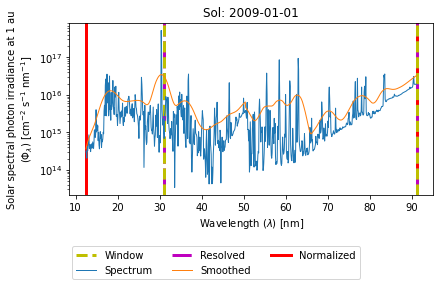

In [4]:
fig, ax = sim.spectrum.plot(var='Phi_wl')

## Generate a new spectrum

In [5]:
my_spectrum = spectrum()

wl_min in lisard_spectrum 5e-09
Min in nm from glq_spectrum.py 0.05
spectrum.py: print norm_span [5.0000e-02 1.8995e+02]
[5.0000e-02 1.8995e+02]
bin_spectrum - bin_breaks[0]: 0.05
truncate_spectrum has been activated and, therefore, bin_spectrum(new_breaks).
normaliz: norm_span 0.05
normalize: rslv_span 0.05
smoothing 0.05
fit polynomial 0.05
window span in abscissa [5.0000e-02 1.8995e+02]
set_abscissa: n_bins =  1


### Adding species

`WARNING`: Currently only hydrogen has been vetted and is capable of being model in the relaxation code.

Now the species in the atmosphere does not alter the stellar spectrum; however, the `spectrum` class also does the heavy lifting of calculating the frequency dependent cross section and outputting that at the approperaite abscissas for the Gauss-Legendre quadrature ionizationg and heating scheme. It is also convient to add the species first, so that later the boundaries of the ionizing spectrum can be determined based off the ionization thresholds of all the species in the planetary outflow.

To add a species for the `spectrum` to track use `spectrum.add_species(name)`, where name is the spectroscopic name of the species, i.e., atomic symbol + ionization stage, e.g., neutral hydrogen is 'H I', neutral helium is 'He I', signlely ionized helium is 'He II', triplely ionized carbon is 'C IV', etc.

In [6]:
my_spectrum.add_species('H I')

[5.00000000e-02 9.11648932e+01 1.89950000e+02]
bin_spectrum - bin_breaks[0]: 0.05
bin_spectrum has been activated.
add_species threshold limiter has been activated. Threshold wl = 91.16489319137749
[5.00000000e-02 9.11648932e+01 1.89950000e+02]
bin_spectrum - bin_breaks[0]: 0.05
truncate_spectrum has been activated and, therefore, bin_spectrum(new_breaks).


### Selecting the domain

The simulation can handle both monochromatic and multifrequency domains. So then the end user may chose how they wish to model the planetary wind's energy source. Although many may find the multifrequency results to be more exciting, there is moderate computational overhead invovled in such simulations. As such, a $\texttt{pro}$ficient end user will ramp between systems with a "decent" monochromatic spectrum, and then polish up their desired system with a multifrequency spectrum.

Now to select the frequency domain can uses `spectrum.window(lob, upb=upb)` and provides a lower boundary (lob), and an upper boundary (upb) of the wavelengths in cgs, i.e., cm. If only a lower bound is provided an upper bound will be automatically determined by finding the lowest ionization threshold amoungst all the species in the spectrum, e.g., for a hydrogen only atmosphere the upper bound will be found to be ~91.2 nm.

For a monochromatic source one can either provide a lower boundary and upper boundary equal to one another, or use `spectrum.monochrome(wavelength)`. All the user needs to provide then is the wavelength in cm that the monochromatic light acts at.

In [8]:
resolved = const.hc/(np.array([100*const.eV, const.RyH])*my_spectrum.wl_norm)
print(resolved)
my_spectrum.set_resolved(*resolved)

[12.39842547 91.17633513]


In [9]:
normalized = const.hc/(np.array([100*const.eV, const.RyH])*my_spectrum.wl_norm)
print(normalized)
my_spectrum.set_normalized(*normalized)

[12.39842547 91.17633513]
spectrum.py: print norm_span [12.39842547 91.17633513]
[12.39842547 91.16489319]
bin_spectrum - bin_breaks[0]: 12.39842547402734
truncate_spectrum has been activated and, therefore, bin_spectrum(new_breaks).
normaliz: norm_span 12.39842547402734
normalize: rslv_span 12.39842547402734
smoothing 12.39842547402734
fit polynomial 12.39842547402734


In [10]:
kind = 'full'
if kind == 'full':
    window = resolved
elif kind == 'mono' or kind == 'fixed':
    window = const.hc/(np.array([20*const.eV])*my_spectrum.wl_norm)
my_spectrum.set_window(*window, kind=kind)

window span in abscissa [12.39842547 91.17633513]
set_abscissa: n_bins =  1


In [13]:
my_spectrum.generate(kind='full', savefile='inputs/test_spectrum.inp')

write_csv n_bins: 1
write_csv: n_subbins [7]
write_csv, npts: 66
ion: 2.178960992e-11


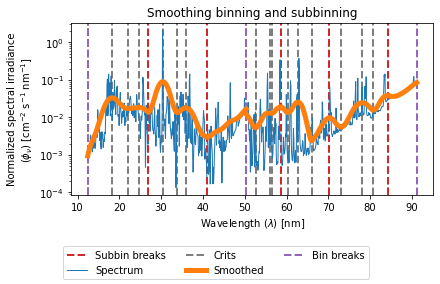

In [11]:
fig, ax = sim.spectrum.glq_spectrum.plot()

### Converging results to new spectrum

A new spectrum shape will alter the results of the simulation, as high energy photons penetrate deeper into the atmosphere. Therefore, just as the other parameters, the system needs to be slowly ramped up from its initial state to its final desired state. This is accomplished by calling the `wind_simulation.ramp_spectrum()` method, which ramps the spectrum to the current spectrum object stored in the `wind_simulation` object.

In [12]:
sim.ramp_spectrum(my_spectrum, debug=False)

ERROR: Species H I not found in prior solution's species list:
       ['H I', 'He I']


### Congratulations

You have now run a full multifrequency simulation of atmospheric escape. As these require a relavtively modest amount of time, it's never a bad idea to save your results if they are interesting. Note that I used 'full_spectrum' for the folder, therefore this fill will be organized under `saves/full_spectrum/`. For the filename the system name, species, and a monkier for our selected spectrum have been combined to form a unquie filename. This will help us distinguish our full spectrum results from our monochromatic results. Consider using both creative filename and folder names (and trees of folders) to efficiently organize your results.

In [ ]:
sim.converge_all_bcs(expedite=False)
sim.save_planet('GJ436b_HI_100-RyH', folder='full_spectrum')

## Tracking multiple simulations

Multiple wrappers objects can be initalized allowing for multiple simulations to be used at once. While the relaxation code working directory is aligned with the last simulation to have issued an execution, the each wrapper is capable of realigning the working directory to that of its own simulation. Therefore, you can start ramping an Earth simulation, put that on pause create a new wrapper object for a complete new Jupiter, mess around with that then pick up with your Earth simulation effortlessly.

As we already saved a GJ 436 b monochromatic simulation, let's create a wrapper object for that simulation. Note that this will not overwrite the working directory until an execution is called, e.g., ramping variables. We also do a nonexpedited load as we are about to do some analysis!

In [3]:
sim_40mono = wind_sim(csv_file='saves/GJ436/b_40eV-RyH_mono.csv')
sim_40mono.load_uservars('saves/GJ436/b_40eV-RyH_mono.csv')

In [4]:
sim_40 = wind_sim(csv_file='saves/GJ436/b_40eV-RyH.csv')
sim_40.load_uservars('saves/GJ436/b_40eV-RyH.csv')

In [5]:
sim_100mono = wind_sim(csv_file='saves/GJ436/b_100eV-RyH_mono.csv')
sim_100mono.load_uservars('saves/GJ436/b_100eV-RyH_mono.csv')

In [ ]:
sim_100 = wind_sim(csv_file='saves/GJ436/b_100eV-RyH.csv')
sim_100.load_uservars('saves/GJ436/b_100eV-RyH.csv')

In [ ]:
sim_40mono = wind_sim(csv_file='saves/Allison/TOI1231b_40eV-RyH_mono.csv')
sim_40mono.load_uservars('saves/Allison/TOI1231b_40eV-RyH_mono.csv')

sim_40 = wind_sim(csv_file='saves/Allison/TOI1231b_40eV-RyH_full.csv')
sim_40.load_uservars('saves/Allison/TOI1231b_40eV-RyH_full.csv')

sim_100 = wind_sim(csv_file='saves/Allison/TOI1231b_100eV-RyH_full.csv')
sim_100.load_uservars('saves/Allison/TOI1231b_100eV-RyH_full.csv')

In [ ]:
fig, ax = plt.subplots(2,2)
four_panel_plot(sim_40.windsoln, ax, label='[40-13.6] eV',
                 sub_sonic=True, past_rmin=False)
four_panel_plot(sim_40mono.windsoln, ax, label='[40-13.6] eV mono',
                sub_sonic=True, past_rmin=False)
four_panel_plot(sim_100.windsoln, ax, label='[100-13.6] eV',
                sub_sonic=True, past_rmin=False)
# four_panel_plot(sim_100mono.windsoln, ax, label='[100-13.6] eV mono',
#                 sub_sonic=True, past_rmin=False)
fig.tight_layout(pad=0.3)
fig.suptitle('Four Panel GJ 436 b Plot')
fig.subplots_adjust(bottom=0.3, top=0.925)
fig.legend(bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=2);

## Analysis

Congratulations! You now know the basics and should have enough to get started simulating your own planets. In this last section we briefly touch on a few core bits of analysis that we feel end users should know how to do. For a bit of fun we will be analysising GJ 436 b for both a 20 eV monochromatic source, and the multifrequency uv spectrum we've defined.

### Massloss rate

If atmospheric escape had to be reduced to a single number this would be it. For every `wind_solution` object created, the maximal 3-D estimated mass-loss rate is always calculated and assigned to `wind_solution.Mdot`. Here we define exactly what the maximal 3-D mass-loss rate is

$$\dot{M}_{\mathrm{3D}} =4 \pi \, r_{c}^2 \, \rho(r_{c}) \, v(r_{c}).$$

Here $r_c$ is the critical point, or sonic radius, $v$ is the velocity of the gas (which is necessarily equal to the sound speed at the critical point), and $\rho$ is the density. As our simulation is 1-D spherically symmetric, then this is certainly an upper limit as the effects of tidal gravity and ionizing flux at the sub-stellar point has the greatest energy injection.

In [ ]:
print(f'[100-13.6] eV monochromatic Mdot = {sim_100.windsoln.Mdot:e} g/s')
print(f'[100-13.6] eV spectrum Mdot      = {sim_100mono.windsoln.Mdot:e} g/s')

In [ ]:
print(f'[40-13.6] eV monochromatic Mdot = {sim_40mono.windsoln.Mdot:e} g/s')
print(f'[40-13.6] eV spectrum Mdot      = {sim_40.windsoln.Mdot:e} g/s')

In [ ]:
print(sim_40mono.windsoln.eff1*sim_40mono.windsoln.F0,
      sim_40.windsoln.eff1*sim_40.windsoln.F0)
print(sim_100mono.windsoln.eff1*sim_100mono.windsoln.F0,
      sim_100.windsoln.eff1*sim_100.windsoln.F0)

### Plotting the solution

Several plots we have found useful for analysis have been stored in `wrapper_utils/plots.py`. All of these functions have already been imported and we will now give a brief overview of them.

#### Quick overview of solution: `four_panel_plot()`

This is the main plotting routine for quickly reviewing the results of the simulations. As it's name suggest it takes in a (2,2) axes object, and plots the velocity, density, temperature, and neutral fraction as a function of radius. For all keyword arguments see `help(four_panel_plot)`.

In [ ]:
fig, ax = plt.subplots(2,2)
four_panel_plot(sim_100mono.windsoln, ax, label='mono',
                sub_sonic=False, past_rmin=True)
four_panel_plot(sim_100.windsoln, ax, label='uv',
                sub_sonic=False, past_rmin=True)
fig.tight_layout(pad=0.3)
fig.suptitle('Four Panel GJ 436 b Plot')
fig.subplots_adjust(bottom=0.225, top=0.925)
fig.legend(bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=2);

#### Energy budget: `energy_plot()`

To see what the energetic rates are as a function of radius one can use this routine. A notable keyword argument is `all_terms`, which if toggled to `True` will plot terms that were not included in the relaxation simulation to sanity check if they would have been relevant. 

In [ ]:
fig, ax = plt.subplots()
energy_plot(sim_100mono.windsoln, ax, sub_sonic=False, all_terms=False)
ax.set_title('Monochromatic')
fig.tight_layout()

fig, ax = plt.subplots()
energy_plot(sim_100.windsoln, ax, sub_sonic=False, all_terms=False)
ax.set_title('Spectrum')
fig.tight_layout()

#### Coriolis analysis: `coriolis_plot()`

As our simulation is 1-D one needs to consider when 3-D effects will substantially alter the results. In a quick overview, we calculate the angle at which the 1-D simulated streamline's momentum would have deflected by one radian as where the Coriolis force starts to play an important role in the outflow. The red-dashed horizontal line equals one radian, while the dashed purple vertical lines represents the Coriolis length, where the angle has been deflected by one radian.

In [ ]:
fig, ax = plt.subplots()
coriolis_plot(sim_100mono.windsoln, ax, var='vel_angle', label_system='mono')
coriolis_plot(sim_100.windsoln, ax, var='vel_angle', label_system='uv')
fig.tight_layout()

#### Knudsen Number `collisionality_plot()`

Some have aired dissent that models such as these are invalid, and rather kinetic models are needed to simulate planetary outflow. The primary issue with these assertions is the reliance on using hardbody scattering as the means of calculating the collisionality of the gas. However, as the outflow is acknowledged to have been launched due to ionization the dominate collisional mechanism will rather be Coulomb scattering. Coulomb scatter is widely known to have a much large cross section than hardbody scattering, and is why these outflows are actually collisional despite objections otherwise.

To drive this point home we plot the Knudsen number using several collisional mechanisms. If your planet is somehow not collisional ($\mathrm{Kn} \gtrsim 1$) by the critical point (the dashed red vertical line), then we also assert the model is beginning to lose appropriateness. Our preferred model is the weighted scheme, which takes into account the neutral's colliding via hardbody and the ions with Coulomb. Note that while neutral-ion coupling has not been explained, the ions typically make up more than 90% of the outflow by the time hardbody scattering reaches $\mathrm{Kn} \sim 1$.

In [ ]:
fig, ax = plt.subplots()
collisionality_plot(sim_100mono.windsoln, ax)
fig.suptitle('GJ 436 b w/monochromatic source', y=1.01)
fig.tight_layout()

fig, ax = plt.subplots()
collisionality_plot(sim_100.windsoln, ax)
fig.suptitle('GJ 436 b w/uv spectrum', y=1.01)
fig.tight_layout()

### Freestyle plotting

Recall that the `wind_solution` object has all the information stored in panda DataFrames and is easily accessible for creating your own custom plots. We provide two interesting plots as a template.

In [ ]:
fig, ax = plt.subplots(1,1)
ax.axhline((sim.windsoln.soln['bern_isen']-sim.windsoln.soln['bern_rogue'])[0],
           alpha=0.5, ls='--', c='gray')
# ax.axhline(0, alpha=0.5, ls='--', c='gray')
ax.axvline(sim.windsoln.rHill, ls='-.', alpha=0.5, c='y')
ax.axvline(sim.windsoln.soln_norm['z'][1]+1, alpha=0.5, ls='--', c='r')
ax.plot(sim.windsoln.soln_norm['r'], sim.windsoln.soln['bern'],
        label='True')
ax.plot(sim.windsoln.soln_norm['r'], sim.windsoln.soln['bern_isen'],
        label='Isentropic')

ax.plot(sim.windsoln.soln_norm['r'],
        -const.G*sim.windsoln.Mp/sim.windsoln.soln['r']
        +sim.windsoln.soln['sp_grav'][0]
        +const.G*sim.windsoln.Mp/sim.windsoln.soln['r'][0],
        alpha=0.5, ls='--', c='gray')

ax.set_ylabel(r'Bernoulli Constant (erg/cm$^{-3}$)')
ax.set_xlabel(r'Radius (R$_p$)')
ax.legend()
ax.set_title(sim.system.name)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
# Plot heating rate and temperature as function of column density
ax2 = ax.twinx()
ax2.plot(np.log10(sim.windsoln.soln['Ncol']), sim.windsoln.soln['heat_ion'],
         label = 'Heating Rate', zorder=10)
ax.plot(np.log10(sim.windsoln.soln['Ncol']), sim.windsoln.soln['T'],
        ls='--', label='Temperature', zorder=10)

ax2.set_ylim([ax2.get_ylim()[1]/1e10, ax2.get_ylim()[1]])
ax2.set_xlim([ax2.get_xlim()[1], ax2.get_xlim()[0]])
ax2.set_yscale('log')
# Roughly peak heating a for monochromatic source
ax2.axvline(np.log10(3./sim.windsoln.sigma_wl.min()), alpha=0.5, ls=':')
sigma_mean = (
    (sim.windsoln.sigma_wl*sim.windsoln.wPhi_wl).sum()/sim.windsoln.Phi0
)
smean = (
    integrate.simps(glq.data_norm['phi_wl'][mk]*glq.species_list[0].sigma[mk],
                    glq.data_norm['wl'][mk])
)
ax2.axvline(np.log10(3./smean), alpha=0.5, ls='-.')
ax2.axvline(np.log10(5./sigma_mean), alpha=0.5, ls=':')
ax.set_xlabel(rf'$\log_{{10}}$(Ncol)')
ax2.set_ylabel(r'Heating Rate [erg/cm$^3$]', rotation=-90, labelpad=30)
ax.set_ylabel(r'Temperature [K]')
ax2.set_xlim([np.log10(30./sim.windsoln.sigma_wl.min()),
             np.log10(sim.windsoln.soln['Ncol'].iloc[-1])])

fig.tight_layout(pad=0.3)
fig.suptitle('Heating rates and Temperature')
fig.subplots_adjust(bottom=0.3, top=0.925)
fig.legend(bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=2);

In [ ]:
fig, ax = plt.subplots()
# Plot heating rate and temperature as function of column density
ax2 = ax.twinx()
ax2.plot(np.log10(sim_100mono.windsoln.soln['Ncol']),
         sim_100mono.windsoln.soln['heat_ion'],
         label = 'mono Heating Rate', zorder=10)
ax2.plot(np.log10(sim_100.windsoln.soln['Ncol']),
         sim_100.windsoln.soln['heat_ion'],
         label = 'uv Heating Rate', zorder=10)
ax.plot(np.log10(sim_100mono.windsoln.soln['Ncol']),
        sim_100mono.windsoln.soln['T'],
        ls='--', label='mono Temperature', zorder=10)
ax.plot(np.log10(sim_100.windsoln.soln['Ncol']),
        sim_100.windsoln.soln['T'],
        ls='--', label='uv Temperature', zorder=10)

ax2.set_ylim([ax2.get_ylim()[1]/1e10, ax2.get_ylim()[1]])
ax2.set_xlim([ax2.get_xlim()[1], ax2.get_xlim()[0]])
ax2.set_yscale('log')
# Roughly peak heating a for monochromatic source
# ax2.axvline(np.log10(3./sim_ruth.windsoln.sigma_wl.min()), alpha=0.5, ls=':')
ax.set_xlabel(rf'$\log_{{10}}$(Ncol)')
ax2.set_ylabel(r'Heating Rate [erg/cm$^3$]', rotation=-90, labelpad=30)
ax.set_ylabel(r'Temperature [K]')
# ax2.set_xlim([np.log10(30./sim_20.windsoln.sigma_wl.min()),
#              np.log10(sim_20.windsoln.soln['Ncol'].iloc[-1])])

fig.tight_layout(pad=0.3)
fig.suptitle('Heating rates and Temperature')
fig.subplots_adjust(bottom=0.3, top=0.925)
fig.legend(bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=2);

In [ ]:
from scipy.optimize import fsolve

def sigma_root(s0, t0, spectrum):
    mk = ((spectrum.data_norm['wl']>=spectrum.norm_span[0])
          &(spectrum.data_norm['wl']<=spectrum.norm_span[1]))
    sigma = spectrum.species_list[0].sigma[mk]/(s0*1e-18)
    E_ratio = ((spectrum.data['E'][mk]-const.RyH)
               /(const.hc/(spectrum.mono_wl*spectrum.wl_norm)-const.RyH))
    phi = spectrum.data_norm['phi_wl_smth'][mk]
    I1 = integrate.simps(E_ratio*sigma*phi*np.exp(-t0*(sigma-1)),
                         spectrum.data_norm['wl'][mk])
    return I1-1.

def d_sigma_root(s0, t0, spectrum):
    mk = ((spectrum.data_norm['wl']>=spectrum.norm_span[0])
          &(spectrum.data_norm['wl']<=spectrum.norm_span[1]))
    sigma = spectrum.species_list[0].sigma[mk]/(s0*1e-18)
    E_ratio = ((spectrum.data['E'][mk]-const.RyH)
               /(const.hc/(spectrum.mono_wl*spectrum.wl_norm)-const.RyH))
    phi = spectrum.data_norm['phi_wl_smth'][mk]
    I1 = integrate.simps(E_ratio*sigma*phi*np.exp(-t0*(sigma-1)),
                         spectrum.data_norm['wl'][mk])
    dI1 = I1/s0*(t0-1)
    return dI1

fsolve(sigma_root, 1e-1, args=(3, my_sim.spectrum), factor=.1, xtol=1e-20)*1e-18

In [ ]:
my_sim = sim_40
fig, ax = plt.subplots()
# Plot heating rate and temperature as function of column density
ax2 = ax.twinx()
ax2.plot(np.log10(my_sim.windsoln.soln['Ncol']),
         my_sim.windsoln.soln['heat_ion'],
         label = 'Heating Rate', zorder=10)
ax.plot(np.log10(my_sim.windsoln.soln['Ncol']),
        my_sim.windsoln.soln['T'],
        ls='--', label='Temperature', zorder=10)

ax2.set_ylim([ax2.get_ylim()[1]/1e10, ax2.get_ylim()[1]])
ax2.set_xlim([ax2.get_xlim()[1], ax2.get_xlim()[0]])
ax2.set_yscale('log')
# Roughly peak heating a for monochromatic source
ax2.axvline(np.log10(3./my_sim.windsoln.sigma_wl.min()), alpha=0.5, ls=':')
sigma_mean = (
    (my_sim.windsoln.sigma_wl*my_sim.windsoln.wPhi_wl).sum()
    /my_sim.windsoln.Phi0
)
glq = my_sim.spectrum.glq_spectrum
mk = ((glq.data_norm['wl']<=my_sim.spectrum.rslv_span[-1])
      &(glq.data_norm['wl']>=my_sim.spectrum.rslv_span[0]))
smean = (
    integrate.simps(glq.data_norm['phi_wl'][mk]*glq.species_list[0].sigma[mk],
                    glq.data_norm['wl'][mk])
)
mysig = fsolve(sigma_root, 1e-1, args=(3, my_sim.spectrum),
               fprime=d_sigma_root, factor=.1, xtol=1e-20)*1e-18
ax2.axvline(np.log10(3./smean), alpha=0.5, ls='-.')
ax2.axvline(np.log10(3./sigma_mean), alpha=0.5, ls='-')
ax2.axvline(np.log10(3./mysig), alpha=0.5, ls='-', c='r')
ax.set_xlabel(rf'$\log_{{10}}$(Ncol)')
ax2.set_ylabel(r'Heating Rate [erg/cm$^3$]', rotation=-90, labelpad=30)
ax.set_ylabel(r'Temperature [K]')
ax2.set_xlim([np.log10(30./my_sim.windsoln.sigma_wl.min()),
             np.log10(sim.windsoln.soln['Ncol'].iloc[-1])])

fig.tight_layout(pad=0.3)
fig.suptitle('Heating rates and Temperature')
fig.subplots_adjust(bottom=0.3, top=0.925)
fig.legend(bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=2);